## ASTR 375 Final Project Dataset Creator 
### Isaac Moskowitz
### Professor Malena Rice, TF Konstantin Gerbig

This jupyter-notebook guides you through the creation of synthetic exomoon transit curves. These curves will represent a wide variety of different star-planet-moon systems, with a great diversity of stellar/planetary mass ratios, moon/planet mass ratios, planetary semi-major axis, and moon orbital semi-major axis. These lightcurves will train the LSTM model on what it may expect to find in real datasets as well as establish limits in parameter space that determine which sytems are most likely to be detected using this method.

In [ ]:
!pwd

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import tensorflow as tf
import sys
import os
os.chdir("/Users/moskowitzi/Desktop/Senior_Year_at_Yale/ASTR-375-Final-Project/")
sys.path.append("/Users/moskowitzi/Desktop/Senior_Year_at_Yale/ASTR-375-Final-Project/MoonPy")
#from moonpy import *
#from moonpy import LightCurve
import batman
from batman import TransitParams
from batman import TransitModel

from astroquery.mast import Catalogs
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
from tqdm import tqdm
import glob

#from moonpy import transitmodel as tm 

%config InlineBackend.figure_format='retina'
plt.rcParams.update({'axes.linewidth' : 1,
                     'ytick.major.width' : 1,
                     'ytick.minor.width' : 1,
                     'xtick.major.width' : 1,
                     'xtick.minor.width' : 1,
                     'xtick.labelsize': 10, 
                     'ytick.labelsize': 10,
                     'axes.labelsize': 12,
                     'font.family': 'Serif',
                     'figure.figsize': (10, 6)
                    })


In [3]:
#ticid = 261105201
#starName = f"TIC {ticid}"
starName = "AU Mic"

# Query the TIC catalog for RA and Dec
from astroquery.vizier import Vizier
result = Vizier.query_object(starName, catalog="IV/38/tic")
ra = result[0]['RAJ2000'][0]
dec = result[0]['DEJ2000'][0]

print(f"Coordinates: RA={ra}, Dec={dec}")

coord = SkyCoord(ra, dec, unit = "deg")
sectorTable = Tesscut.get_sectors(coordinates=f"{ra} {dec}")
print(sectorTable)

obsTable = Observations.query_criteria(
    objectname=starName,
    obs_collection="TESS",
    dataproduct_type="timeseries",
    project="TESS"
)

print(f"Found {len(obsTable)} light curves")
data_products = Observations.get_product_list(obsTable[0])
object_manifest = Observations.download_products(data_products, productSubGroupDescription='LC') # to download the lightcurve
lightcurve_files = [f for f in object_manifest['Local Path'] if f.endswith('.fits')]
print(len(lightcurve_files))

Coordinates: RA=311.28608498301, Dec=-31.37181471254


  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0001-1-4      1      1   4
tess-s0027-1-3     27      1   3


NameError: name 'Observations' is not defined

In [4]:
def phase_fold(period, time_series_data): # From ASTR 225 Problem Set 4
    time_series_data = np.asarray(time_series_data)
    phi = (time_series_data/period) % 1
    return phi

#stack = fits.open("mastDownload/TESS/tess2019006130736-s0007-0000000261105116-0131-s/tess2019006130736-s0007-0000000261105116-0131-s_lc.fits")
#stack = fits.open("mastDownload/TESS/tess2020020091053-s0021-0000000332064601-0167-s/tess2020020091053-s0021-0000000332064601-0167-s_lc.fits")
stack = fits.open("mastDownload/TESS/tess2020186164531-s0027-0000000441418475-0189-s/tess2020186164531-s0027-0000000441418475-0189-s_lc.fits")
#print(stack[1].header)
period = 8.46308 # From the IPAC NASA Exoplanet Archive, derived by Wittrock et al. (2023)
fluxes = stack[1].data['PDCSAP_FLUX']
quality_flags = stack[1].data["QUALITY"]
time_data = stack[1].data['TIME']
#error_data = stack[1].data["ERROR"]
header = stack[1].header
print(header)
print(np.shape(fluxes))
print(np.shape(time_data))

good_quality_mask = (quality_flags == 0)

new_times = time_data[good_quality_mask]
new_fluxes = fluxes[good_quality_mask]

phases = phase_fold(period, new_times)

print(np.shape(new_times))
print(np.shape(new_fluxes))

print(np.shape(new_times))
print(np.shape(new_fluxes))

plt.scatter(new_times, new_fluxes, color = 'k', s = 1)

plt.xlabel("Time")
plt.ylabel("Flux")
#plt.ylim(5800, 5850)
plt.show()

plt.scatter(phases, new_fluxes, color = 'k', s = 1)

plt.xlabel("Phase")
plt.ylabel("Flux")
#plt.ylim(5800, 5850)
plt.show()

# Now that we have the lightcurve data, we can use MoonPy to detrend to extract intrinsic variability. 

#lc_object = MoonpyLC(targetID = 'usr',lc_times = new_times, lc_fluxes = new_fluxes, load_lc = 'y')
#lc_object = MoonpyLC(targetID='usr')

KeyboardInterrupt: 

In [ ]:
# Test script to make sure that we can create a transit for exomoon purposes. Variable values are taken from the batman code github: 

params = batman.TransitParams()
params.t0 = 0.                        #time of inferior conjunction
params.per = 1.                       #orbital period
params.rp = 0.1                       #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 87.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

# Exomoon: 

moon_params = batman.TransitParams()
moon_params.t0 = 0.005                
moon_params.per = 0.2                 
moon_params.rp = 0.02                
moon_params.a = 0.5                   
moon_params.inc = 90.0                
moon_params.ecc = 0.0                
moon_params.w = 90.0                  
moon_params.limb_dark = "nonlinear"   
moon_params.u = [0.5, 0.1, 0.1, -0.1] 

#t = np.linspace(-0.025, 0.025, 1000)  #times at which to calculate light curve
t = np.linspace(0, 1.0, 16779)
m_planet = batman.TransitModel(params, t)    #initializes model
m_moon = batman.TransitModel(moon_params, t)
planet_flux = m_planet.light_curve(params) 
moon_flux = m_moon.light_curve(moon_params)
#radii = np.linspace(0.09, 0.11, 20)
combined_flux = planet_flux * moon_flux # assuming that the transit events happen independently. Is this a reasonable approximation / is this a 
#physical way to calculate this?
#noise_level = 0.0005  # Noise standard deviation (adjust as needed)
#noisy_flux = combined_flux + np.random.normal(0, noise_level, len(combined_flux))
#for r in radii:
    #params.rp = r                           #updates planet radius
    #new_flux = m.light_curve(params)        #recalculates light curve
plt.figure(figsize=(8, 5))
plt.plot(t, planet_flux, label="Planet Transit", linestyle="--", alpha=0.7)
plt.plot(t, moon_flux, label="Exomoon Transit", linestyle=":", linewidth = 2)
plt.plot(t, combined_flux, label="Combined Transit", color="midnightblue", linestyle="-", alpha = 0.7)
plt.title("Model Transit Plot (Planet & Exomoon)")
plt.xlabel("Time from central transit (days)")
plt.ylabel("Relative flux")
plt.ylim((0.987, 1.001))
plt.legend()
plt.show()

In [5]:
def kepler_3rd_law(mass_planet, mass_moon, a):
    G = 6.67*10**(-11) # in SI units
    return np.sqrt(4*np.pi**2/((mass_planet + mass_moon) * G) * a**3)
def mass_radius_polytrope(R): # assuming a polytropic equation of state for the rocky moon (not entirely accurate, but will do for now)
    # citation: https://iopscience.iop.org/article/10.3847/0004-637X/819/2/127
    #R = M**0.27 
    M = R**1/0.27 # this is a proportion, so the radius is described in Jupiter radii
    return M

In [ ]:
# Lets first create a Jupiter mass planet and compare different moon-mass distributions within the Jovian system.
solar_mass = 1.989*10**30
solar_radius = 6.96*10**8
AU = 1.496*10**11 # meters
#jupiter_a = 778.479 * 10**6 / solar_radius
earth_a = 215.032 # number of solar radii in an AU
jupiter_radius = 7.1492*10**7
planet_radius = jupiter_radius / solar_radius
jupiter_mass = 1.898*10**27


ganymede_mass  = 1.4819*10**23 / jupiter_mass
#ganymede_mass_sun = 1.4819*10**23 / solar_mass
ganymede_radius = 2634.1 * 1000 / jupiter_radius
europa_mass = 4.79984*10**22 / jupiter_radius
europa_radius = 1560.8 * 1000 / jupiter_radius
europa_period = 3.551
ganymede_period = 7.15455296 #days
ganymede_a = 14.97 
europa_a = 9.40 # Jupiter radii


planet_mass = jupiter_mass / solar_mass
jupiter_orbital_period = 4332.59 

planet_orbital_period = np.sqrt(4 * np.pi**2/(6.67*10**(-11) * (solar_mass + jupiter_mass)) * (1.496*10**11)**3)/(3600*24)
print(planet_orbital_period)
ganymede_period_relative = jupiter_orbital_period / ganymede_period
#moon_radius = np.random.uniform(europa_radius, ganymede_radius, size = 16)
#moon_radius = [europa_radius, ganymede_radius]
moon_radius = [europa_radius * 1.5, ganymede_radius * 1.5]  # Slightly larger for visualization
#moon_periods = np.random.uniform(
#times = np.linspace(0, 2, 17000)
times = np.linspace(-0.025, 0.025, 17000)
combined_fluxes = []
moon_fluxes = []
planet_fluxes = []
print(moon_radius)
for ii, r in tqdm(enumerate(moon_radius)):
    params1 = batman.TransitParams()
    params1.t0 = 0.0
    params1.per = planet_orbital_period
    params1.rp = planet_radius
    params1.a = earth_a
    params1.inc = 89.6
    params1.ecc = 0.0489
    params1.w = 90.0
    params1.limb_dark = "nonlinear"   
    params1.u = [0.5, 0.1, 0.1, -0.1] 

    params_moon = batman.TransitParams()
    params_moon.t0 = 0.0
    if ii % 2 == 0:
        moon_mass = europa_mass
        period = europa_period
        semimajor = europa_a
    else:
        moon_mass = ganymede_mass
        period = ganymede_period
        semimajor = ganymede_a
        
    #moon_mass = mass_radius_polytrope(m_r)

    # REMEMBER: We want to model the orbital dynamics of the moon around the planet, so we want batman to think that the "sun" parameter is actually a planet
    # all relative paramneters are calculated in terms of the planet. 
    moon_mass_scaled = moon_mass * solar_mass
    #print(moon_mass_scaled)
    params_moon.rp = r
    #period = kepler_3rd_law(jupiter_mass, moon_mass_scaled, jupiter_a*solar_radius)*3600
    #print(period)
    params_moon.t0 = 0.001
    params_moon.a = semimajor
    params_moon.per = period
    params_moon.inc = 90.0
    params_moon.ecc = 0.0013
    params_moon.w = 90.0
    params_moon.limb_dark = 'nonlinear'
    params_moon.u = [0.5, 0.1, 0.1, -0.1]     

    m1 = batman.TransitModel(params1, times)
    m_moon = batman.TransitModel(params_moon, times)
    flux1 = m1.light_curve(params1)
    flux_moon = m_moon.light_curve(params_moon)

    combined_flux = flux_moon*flux1
    combined_fluxes.append(combined_flux)
    planet_fluxes.append(flux1)
    moon_fluxes.append(flux_moon)

# Visualize the different lightcurves
fig, ax = plt.subplots(1, 2, figsize = (10,10))
print(combined_flux)
print(planet_flux)
counter=0
for ii in range(2):
    #for j in range(1):
    planet_flux = planet_fluxes[ii]
    moon_flux = moon_fluxes[ii]
    combined_flux = combined_fluxes[ii]
    ax[ii].plot(times, planet_flux, label="Planet Transit", linestyle="--", alpha=0.7)
    ax[ii].plot(times, moon_flux, label="Exomoon Transit", linestyle=":", linewidth = 2)
    ax[ii].plot(times, combined_flux, label="Combined Transit", color="midnightblue", linestyle="-", alpha = 0.7)
    #ax[ii][j].settitle("Model Transit Plot (Planet & Exomoon)")
    ax[ii].set_xlabel("Time from central transit (days)")
    ax[ii].set_ylabel("Relative flux")
    #ax[ii].set_ylim((0.987, 1.001))
    ax[ii].set_ylim((0.995, 1.001))
    ax[ii].legend()
    counter+=1

plt.tight_layout()
plt.show()
        

**Pivoting slightly!** We are going to use Pandora, a code imported within the MoonPy package to model exomoon and exoplanet transits, fit these models to observed lightcurves, and analyze the posterior distribution of orbital parameters of the system. The following scripts will create $100,000$ lightcurves of transiting exoplanet-exomoon systems for a variety of physical parameters. We will generate lightcurves for Sun-like stars and red dwarfs, with planetary masses chosen from a uniform distribution $$M_{planet} \in (M_{Earth}, 15 M_{Jupiter})$$ and radii similarly drawn from $$ a \in (0.05, 15)AU$$. The mass of the exomoon will vary according to $$ M_{moon} \in (M_{Europa}, M_{Earth})$$
Making sure that the moon mass never exceeds $2\%$ of the planet mass, corresponding to a little more than the ratio between Earth and the Moon's mass. 

In [10]:
def mean_anomaly(P, e, omega_deg, b=0, a_over_R=None):
    omega = np.radians(omega_deg)

    if b == 0 or a_over_R is None:
        f = np.pi / 2 - omega
    else:
        cos_f = -e + (1 + e * np.cos(omega)) * b / a_over_R
        f = np.arccos(cos_f)
    f_transit = np.pi / 2 - omega
    E = 2 * np.arctan(np.tan(f_transit / 2) * np.sqrt((1 - e) / (1 + e)))
    if E < 0:
        E += 2 * np.pi
    M = E - e * np.sin(E)
    delta_t = (P / (2 * np.pi)) * M
    return delta_t

365.15402662542544


2it [00:00, 158.71it/s]

780.1373919149763
time_array shape: (1603,)
time_array range: 776.9301565608614 to 783.3446272690912
(1603,)
780.1373919149763
time_array shape: (1603,)
time_array range: 776.9301565608614 to 783.3446272690912
(1603,)


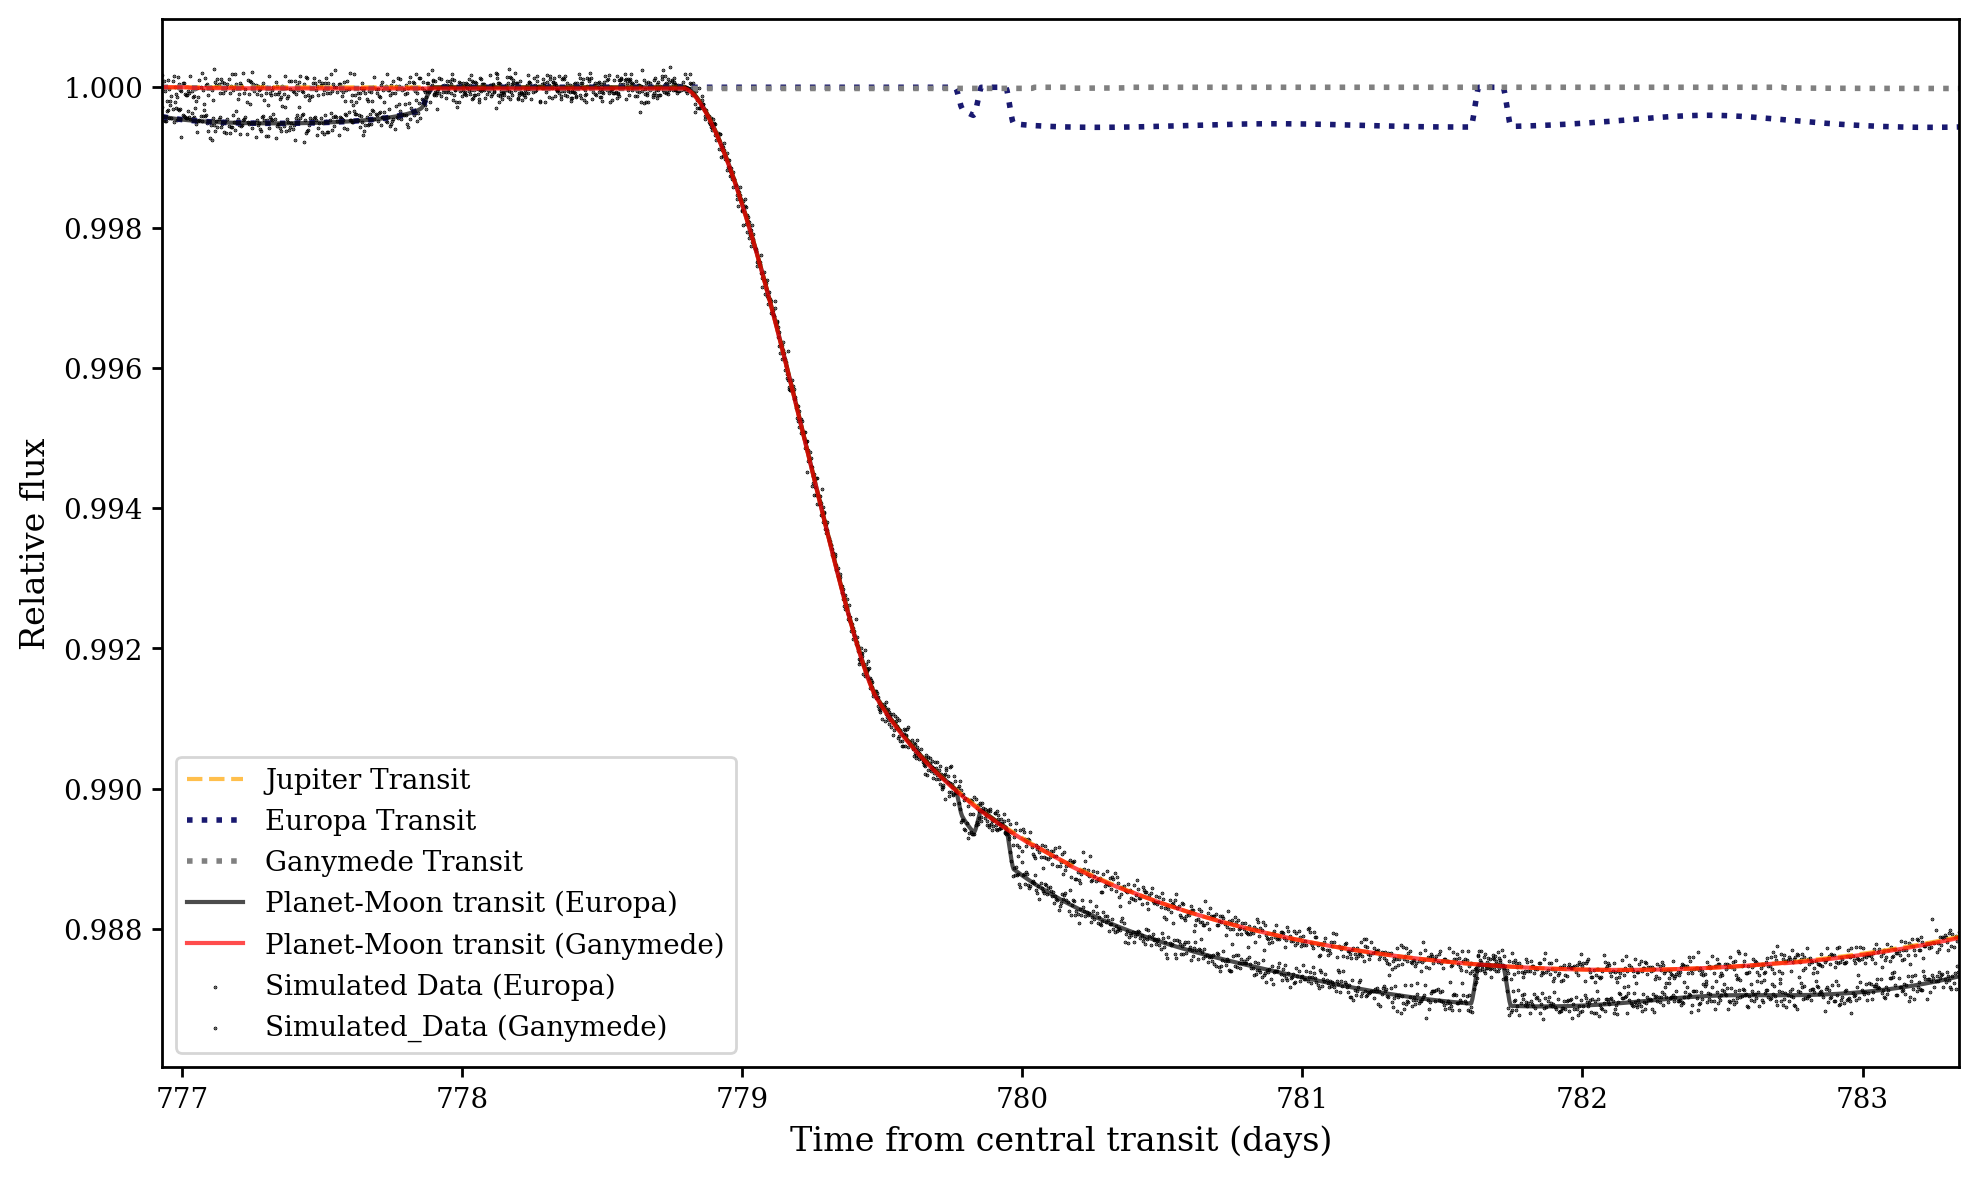

In [33]:
#sys.path.append("/Users/moskowitzi/Desktop/Senior_Year_at_Yale/ASTR-375-Final-Project/Pandora/")
#from pandoramoon import *
from pandoramoon import pandora, model_params, moon_model, time
#from pandora import *
#from pandoramoon import pandora
#from pandoramoon import pandora
#print(dir(pandoramoon))

#import pandoramoon as pandora
#from numba import jit

# Test from the batman code implementation. Let's see how accurate the lightcurve of Ganymede and Europa are when orbiting Jupiter if observed from 
# a distant star. 
solar_mass = 1.989*10**30
solar_radius = 6.96*10**8
#AU = 1.496*10**11 # meters
#jupiter_a = 778.479 * 10**6 / solar_radius
jupiter_a = 215 # solar radii
#earth_a = 215.032 # number of solar radii in an AU
jupiter_radius = 7.1492*10**7
planet_radius = jupiter_radius / solar_radius
jupiter_mass = 1.898*10**27


ganymede_mass  = 1.4819*10**23 / solar_mass
#ganymede_mass_sun = 1.4819*10**23 / solar_mass
ganymede_radius = 2634.1 * 1000 / solar_radius
europa_mass = 4.79984*10**22 / jupiter_radius
europa_radius = 1560.8 * 1000 / jupiter_radius
europa_period = 3.551
ganymede_period = 7.15455296 #days
ganymede_a = 14.97 
europa_a = 9.40 # Jupiter radii


planet_mass = jupiter_mass / solar_mass
jupiter_orbital_period = 4332.59 

planet_orbital_period = np.sqrt(4 * np.pi**2/(6.67*10**(-11) * (solar_mass + jupiter_mass)) * (1.496*10**11)**3)/(3600*24)
print(planet_orbital_period)
ganymede_period_relative = jupiter_orbital_period / ganymede_period
#moon_radius = np.random.uniform(europa_radius, ganymede_radius, size = 16)
#moon_radius = [europa_radius, ganymede_radius]
moon_radius = [europa_radius, ganymede_radius]  # Slightly larger for visualization
#moon_periods = np.random.uniform(
#times = np.linspace(0, 2, 17000)
#times = np.linspace(-0.025, 0.025, )
combined_fluxes = []
moon_fluxes = []
planet_fluxes = []
planet_coords = []
moon_coords = []
times = []
test_data_combined = []
for ii, r in tqdm(enumerate(moon_radius)):
    params = model_params()
    params.R_star = 696_342_000
    params.u1 = 0.4089
    params.u2 = 0.2556
    params.per_bary = jupiter_orbital_period
    params.a_bary = jupiter_a  
    params.r_planet = planet_radius 
    params.b_bary = 0.3 
    #params.t0_bary = 689.7
    params.t0_bary_offset = 2  
    params.M_planet = jupiter_mass 
    params.w_bary = 20.0 
    params.ecc_bary = 0.0487   
    params.t0_bary = mean_anomaly(params.per_bary, params.ecc_bary, params.w_bary, b=params.b_bary, a_over_R = jupiter_a)
    print(params.t0_bary)
    
    # Moon parameters
    params.r_moon = r
    if ii % 2 == 0:
        params.per_moon = europa_period
        params.e_moon = 0.009 
        params.i_moon = 90-1.791
        params.M_moon = 2.529 * 10**(-5) * params.M_planet
    else:
        params.per_moon = ganymede_period
        params.e_moon = 0.0013
        params.i_moon = 90-2.214
        params.M_moon = 7.807 * 10**(-5) * params.M_planet
    params.Omega_moon = 0.0  
    params.tau_moon = mean_anomaly(params.per_moon, params.e_moon, params.Omega_moon)

    params.epochs = 1
    params.epoch_duration = params.per_bary/np.pi * np.arcsin(1/params.a_bary)     
    #params.baseline = 1                  # ±1 day from t0
    params.cadences_per_day = 250        # 2-minute cadence
    #params.epochs = 1
    #params.epoch_distance = params.per_bary
    params.epoch_distance = jupiter_orbital_period
    params.supersampling_factor = 1.0
    params.occult_small_threshold = 0.001
    params.hill_sphere_threshold = 1000

    time_array = time(params).grid()
    print(f"time_array shape: {time_array.shape}")
    print(f"time_array range: {np.min(time_array)} to {np.max(time_array)}")
    times.append(time_array)
    model = moon_model(params)
    flux_total, flux_planet, flux_moon = model.light_curve(time_array)
    print(np.shape(flux_total))
    #print("flux_total", flux_total)
    #print("flux_planet", flux_planet)
    #print("flux_moon", flux_moon)
    moon_fluxes.append(flux_moon)
    planet_fluxes.append(flux_planet)

    xp, yp, xm, ym = model.coordinates(time_array)
    planet_coords.append((xp, yp))
    moon_coords.append((xm, ym))
    noise_level = 100e-6 # Gaussian noise -- would this reflect the noise-profile of TESS?
    noise = np.random.normal(0, noise_level, len(time_array))
    test_data = noise + flux_total
    yerr = np.full(len(test_data), noise_level)
    #print(test_data)
    combined_fluxes.append(flux_total)
    test_data_combined.append(test_data)


#fig, ax = plt.subplots(1, 2, figsize = (10,10))
#print(combined_fluxes)
#print(planet_fluxes)
#for ii in range(2):
#for j in range(1):

plt.plot(times[0], planet_fluxes[0], label="Jupiter Transit", color = 'orange', linestyle="--", alpha=0.7)
plt.plot(times[0], moon_fluxes[0], label="Europa Transit", linestyle=":", color = 'midnightblue', linewidth = 2)
plt.plot(times[1], moon_fluxes[1], label="Ganymede Transit", linestyle=":", color = 'gray', linewidth = 2)
plt.plot(times[0], combined_fluxes[0], label="Planet-Moon transit (Europa)", color="black", linestyle="-", alpha = 0.7)
plt.plot(times[1], combined_fluxes[1], label="Planet-Moon transit (Ganymede)", color="red", linestyle="-", alpha = 0.7)
plt.scatter(times[0], test_data_combined[0], label = "Simulated Data (Europa)", color = 'black', s = 0.1)
plt.scatter(times[1], test_data_combined[1], label = "Simulated_Data (Ganymede)", color = "black", s = 0.1)
#ax[ii][j].settitle("Model Transit Plot (Planet & Exomoon)")
plt.xlabel("Time from central transit (days)")
plt.ylabel("Relative flux")
plt.xlim(np.min(times), np.min(times)+params.epoch_duration)
#ax[ii].set_ylim((0.987, 1.001))
#ax[ii].set_ylim((0.995, 1.001))
plt.legend()

plt.tight_layout()
plt.show()

Ok it seems like the exomoon signal *is* detectable in the data! Now lets create a dataset using the parameter range shown above. We'll first define the masses we seek to use and then create a `for` loop that will loop through all of the parameter combinations and create a tensorflow ragged tensors to reflect the variable length of observation that TESS will do and allow the model to model the lightcurves even with this variable input.

In [34]:
!pwd

/Users/moskowitzi/Desktop/Senior_Year_at_Yale/ASTR-375-Final-Project


In [35]:
def terrestrial_radius(mass): # make sure masses and radii are normalized to a reference point!
    return mass**(0.28)
# Conversion factors
solar_mass = 1.989 * 10**30 # kg
solar_radius = 6.95700*10**8 # m

min_star_mass = 0.079 * solar_mass
min_star_radius = 0.102 * solar_radius

max_star_mass = 6 * solar_mass
max_star_radius = max_star_mass**0.8

jupiter_mass = 1.898 * 10**27 # kg
jupiter_radius = 7.1492*10**7 # m
neptune_mass = 1.024 * 10**26 # kg
neptune_radius = 2.4764 *10**3 # m
earth_mass = 5.9722*10**24 #kg
earth_radius = 6.3781*10**6 # m
super_earth_mass = 10*earth_mass # guides for super_earth parameters, numbers vary
super_earth_radius = 1.2 * earth_radius

# Orbital characteristics
min_a = 0.2877 * 1.496 * 10**11 # orbital radius in meters
max_a = 778479000000 # orbit of Jupiter in meters

# Moon characteristics
min_moon_mass = 4.79984 * 10**22 # Europa, kg
max_moon_mass = earth_mass
min_moon_radius = 1.5608 * 10**3 # m Europa
max_moon_radius = earth_radius

moon_mass_ranges = 10**(np.random.uniform(np.log10(min_moon_mass), np.log10(max_moon_mass), size=200))
#planet_mass_ranges =np.random.uniform(super_earth_mass, 10*jupiter_mass, size = 2000)
log_earth = np.log10(earth_mass)
log_super_earth = np.log10(super_earth_mass)
terrestrial_mass_ranges = 10**(np.random.uniform(log_earth, log_super_earth, size=200))
np.sort(terrestrial_mass_ranges)

neptunian_mass_ranges = 10**(np.random.uniform(log_super_earth, np.log10(jupiter_mass), size = 200))
np.sort(neptunian_mass_ranges)

jovian_mass_ranges = 10**(np.random.uniform(np.log10(jupiter_mass), np.log10(10*jupiter_mass), size=200))
np.sort(jovian_mass_ranges)

planet_a_ranges = 10**(np.random.uniform(np.log10(min_a), np.log10(max_a), size = 200))
solar_radii = 10**(np.random.uniform(np.log10(min_star_radius), np.log10(max_star_radius), size = 200))



# All simulations for a sun-like star
for planet_mass in tqdm(terrestrial_mass_ranges):
    #for a_meters in tqdm(planet_a_ranges):
    a_meters = np.random.choice(planet_a_ranges, size=1)[0]
    #print(a_meters)
    params = model_params()
    params.R_star = solar_radius  # [m]
    params.u1 = 0.4089
    params.u2 = 0.2556
    a_pl = a_meters / params.R_star
    eccentricity = np.random.rand()
    params.ecc_bary = eccentricity 
    params.a_bary = a_pl
    params.b_bary = np.random.rand()
    planet_radius = terrestrial_radius(planet_mass/solar_mass) # in stellar units
    params.r_planet = planet_radius
    period = kepler_3rd_law(solar_mass, planet_mass, a_meters)
    params.per_bary = period * 1/3600 * 1/24
    params.w_bary = 20
    params.t0_bary = mean_anomaly(period, eccentricity, params.w_bary, b=params.b_bary, a_over_R=a_pl)
    params.t0_bary_offset = 0
    params.M_planet = planet_mass


    # Moon parameters
    for moon_mass in moon_mass_ranges:
        moon_radius = terrestrial_radius(moon_mass/solar_mass) # assuming rocky moons that have a similar empirical relation as rocky planets
        hill_radius = params.a_bary**(3) * np.sqrt(params.M_planet/ (solar_mass+params.M_planet))
        params.r_moon = moon_radius
        moon_a = np.random.uniform(0.01*hill_radius, 0.5*hill_radius)
        params.per_moon = kepler_3rd_law(planet_mass, moon_mass, moon_a) * 1/3600 * 1/24
        params.Omega_moon = 0
        params.tau_moon = mean_anomaly(params.per_moon, 0.001, params.Omega_moon)
        params.w_moon = 20
        params.e_moon = 0.001
        params.i_moon = np.random.uniform(80, 90)
        params.M_moon = moon_mass

        params.epochs = 1  # [int]
        #params.epoch_duration = 0.6  # [days]
        transit_time = params.per_bary / np.pi * np.arcsin(1/params.a_bary * np.sqrt(1-params.b_bary**2)) * np.sqrt(1-params.ecc_bary**2)/(1+params.ecc_bary*np.sin(params.w_bary))
        #print(transit_time)
        params.epoch_duration = transit_time
        params.cadences_per_day = 250  # [int]
        params.epoch_distance = 365.24   # [days]
        params.supersampling_factor = 1  # [int]
        params.occult_small_threshold = 0.1  # [0..1]
        params.hill_sphere_threshold = 1.2


        time_array = time(params).grid()
        
        model = moon_model(params)
        flux_total, flux_planet, flux_moon = model.light_curve(time_array)
        #print("flux_total", flux_total)
        #print("flux_planet", flux_planet)
        #print("flux_moon", flux_moon)
    
        xp, yp, xm, ym = model.coordinates(time_array)
        planet_coords.append((xp, yp))
        moon_coords.append((xm, ym))
        noise_level = 100e-6 # Gaussian noise -- would this reflect the noise-profile of TESS?
        noise = np.random.normal(0, noise_level, len(time_array))
        test_data = noise + flux_total
        #tensor_input = np.expand_dims(tensor_input, axis=-1)
        yerr = np.full(len(test_data), noise_level)
        data = {
            'time':time_array,
            'flux_planet': flux_planet,
            'flux_moom': flux_moon,
            'flux_total': flux_total,
            'lc_data': test_data,
            'yerr': yerr
        }
        df = pd.DataFrame(data)
        df.to_csv(f"datasets/terrestrial_lightcurves/a_{a_meters}_planet_mass_{planet_mass}_moon_mass_{moon_mass}.csv")

            #ragged_light_curve = tf.ragged.constant(tensor_input)
            #serialized = tf.io.serialize_tensor(ragged_tensor)
           
            #print(test_data)

        


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:46<00:00,  1.20it/s]


In [18]:
!pwd

/Users/moskowitzi/Desktop/Senior_Year_at_Yale/ASTR-375-Final-Project


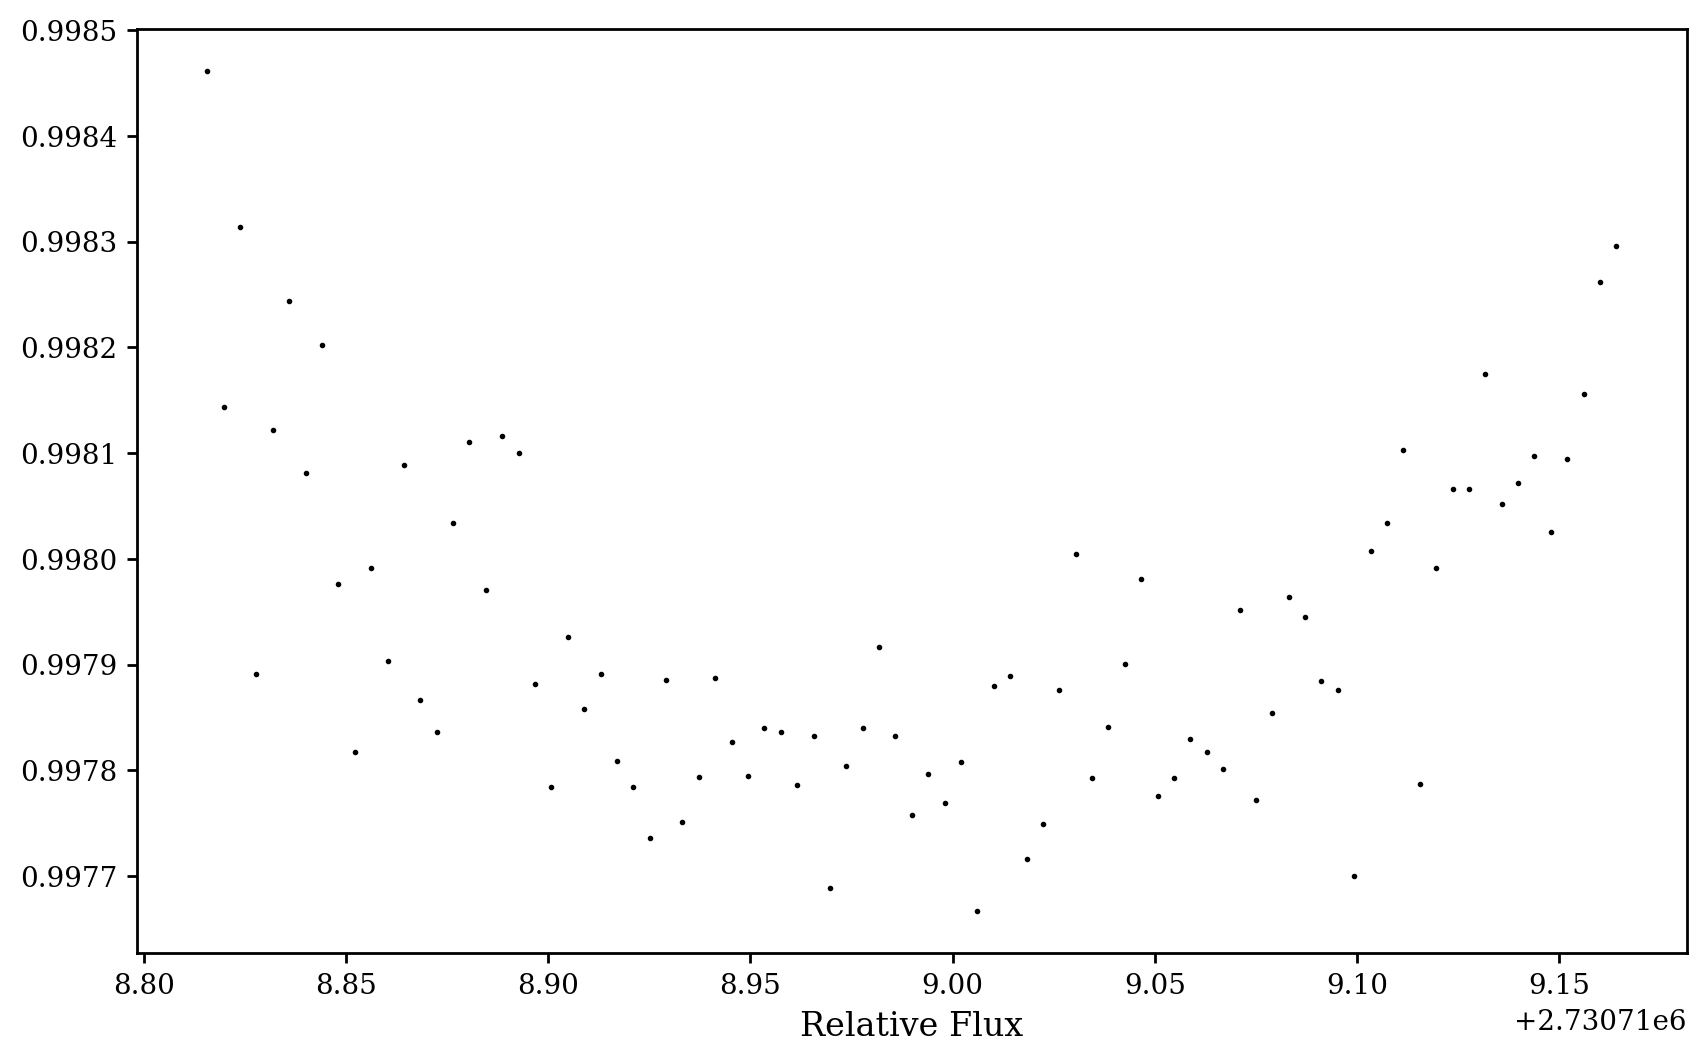

In [44]:
# Lets visualize the lightcurves
np.random.seed(42)
lightcurve_filepaths = glob.glob("datasets/terrestrial_lightcurves/*.csv")
random_selection = np.random.choice(lightcurve_filepaths, size = 1)[0]
df = pd.read_csv(random_selection)
plt.scatter(df['time'], df['lc_data'], s = 1, color = 'black')
plt.xlabel("Time [Julian Day]")
plt.xlabel("Relative Flux")
plt.show()
